This notebook is created for predicting the probability of a person having a stroke based on 10 features - gender, age, hypertension, cardiovascular diseases, average blood glucose level, family and work status, place of residence, height, weight and smoking.

**Atribute information**
* id: unique identifier
* gender: "Male", "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index that counted as weight divided by height
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
* stroke: 1 if the patient had a stroke or 0 if not
* Note: "Unknown" in smoking_status means that the information is unavailable for this patient</i>

In [4]:
import pandas as pd 
import numpy as np 

from tqdm import tqdm 
import matplotlib.pyplot as plt

when large datasets and massive loops are being processed behind the screen, it seems like an eternity of waiting time till the whole process is completed. Thus, Creating a Progress Bar would solve this problem.
tqdm is a library in Python which is used for creating Progress Meters or Progress Bars

In [5]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
plt.style.use('ggplot')

In [7]:
import seaborn as sns 
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier,plot_tree 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier



**KFold vs StratifiedKFold**
* When we are dealing with classification problem of imbalance class distribution, we have to use StratifiedKFold.
* KFold devides the dataset into k folds.
* Where as Stratified ensures that each fold of dataset has the same proportion of observations with a given label.
* For example, if we have a dataset with 10% of category A and 90% of category B, and we use stratified cross-validation, we will have the same proportions in training and validation. In contrast, if we use simple cross-validation, in the worst case we may find that there are no samples of category A in the validation set.

**Recursive Feature Elimination (RFE)**
* It reduces model complexity by removing features one by one until the optimal number of features is left.

* It is one of the most popular feature selection algorithms due to its flexibility and ease of use.
* The algorithm can wrap around any model, and it produces the best possible set of features that gives the highest performance.

In [8]:
train = pd.read_csv('/kaggle/input/stroke-prediction-dataset/train data.csv')
test = pd.read_csv('/kaggle/input/stroke-prediction-dataset/test data.csv')
submission = pd.read_csv('/kaggle/input/stroke-prediction-dataset/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (15304, 12)
The dimession of the test dataset is: (10204, 11)


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [11]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [12]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [13]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [14]:
test.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000
mean,20405.500000,41.920713,0.051450,0.021756,89.197766,28.242351
std,2945.785407,21.097956,0.220925,0.145894,25.914364,6.733863
min,15304.000000,0.080000,0.000000,0.000000,55.120000,11.500000
25%,17854.750000,26.000000,0.000000,0.000000,75.060000,23.700000
50%,20405.500000,43.500000,0.000000,0.000000,85.070000,27.700000
75%,22956.250000,57.000000,0.000000,0.000000,96.750000,32.000000
max,25507.000000,82.000000,1.000000,1.000000,267.600000,97.600000


**Explorating the Data**

Percentage distribution of stroke vs non-stroke population.

In [16]:
round(100*train['stroke'].value_counts()/train.shape[0],2)

0    95.87
1     4.13
Name: stroke, dtype: float64

<AxesSubplot:xlabel='stroke', ylabel='count'>

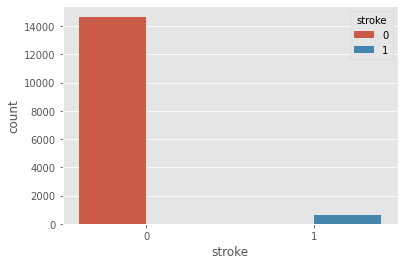

In [20]:
sns.countplot(data=train,x='stroke',hue='stroke')

The data set has highly imbalanced class. ( more than 90% are 0s)

Drawing relationship between numerical features and target variable.

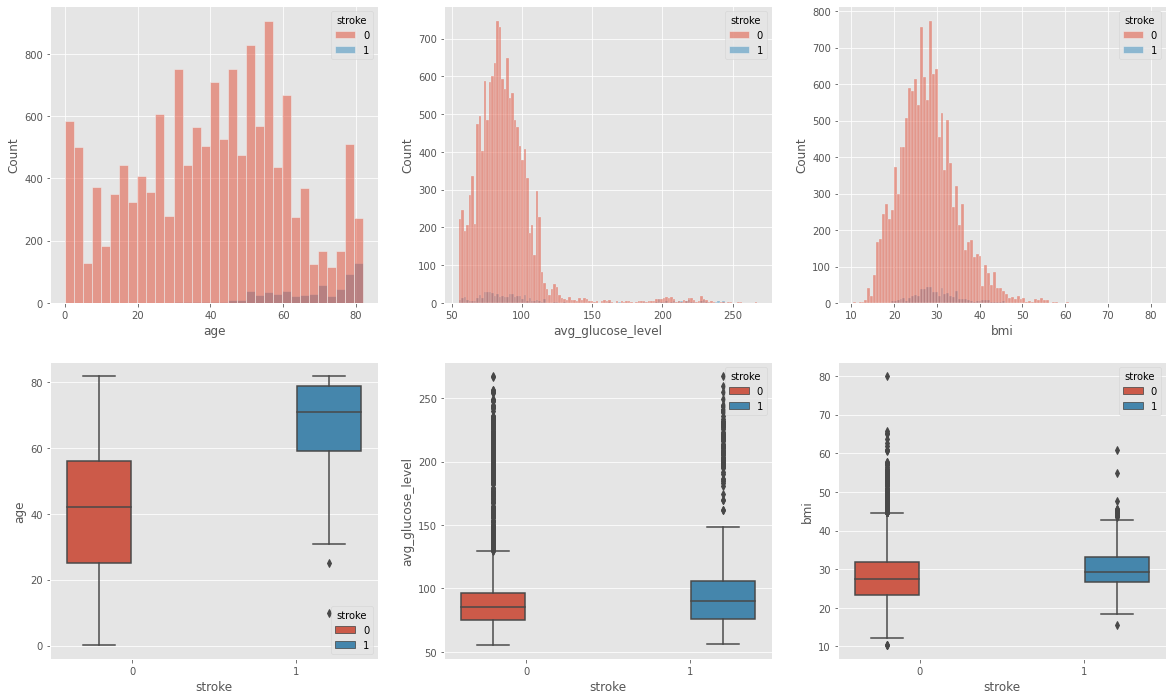

In [21]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.histplot(ax = axes[0, 0], x = 'age', hue = 'stroke', fill = True, data = train)
sns.histplot(ax = axes[0, 1], x = 'avg_glucose_level', hue = 'stroke', fill = True, data = train)
sns.histplot(ax = axes[0, 2], x = 'bmi', hue = 'stroke', fill = True, data = train)
sns.boxplot(ax = axes[1, 0], x = 'stroke', y = 'age', hue = 'stroke', data = train)
sns.boxplot(ax = axes[1, 1], x = 'stroke', y = 'avg_glucose_level', hue = 'stroke', data = train)
sns.boxplot(ax = axes[1, 2], x = 'stroke', y = 'bmi', hue = 'stroke', data = train);

Insight: the older patients are more likely to have a stroke. From the center and right panels (top and bottom), we see that there is a lot of overlapping in the avg_glucose_level and bmi distributions of patients with and without stroke, respectively.

Next, we explore the relationship between categorical input features and the target variables.

**catplot shows frequencies (or optionally fractions or percents) of the categories of one, two or three categorical variables.**

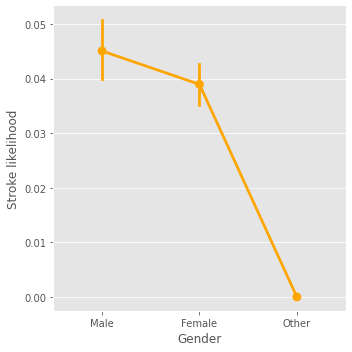

In [23]:
plot1=sns.catplot(data=train,x='gender',y='stroke',kind='point',color='orange')
plot1.set_xlabels("Gender")
plot1.set_ylabels("Stroke likelihood")

Males have a little more proababilty of having the stroke than female.


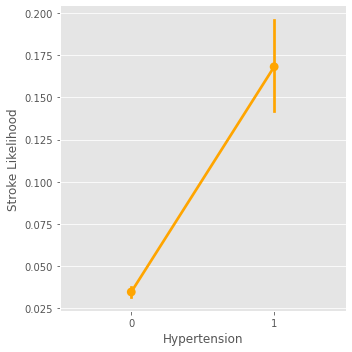

In [24]:
plot1 = sns.catplot(data = train, x = 'hypertension', y = 'stroke', kind = 'point', color = 'orange')
plot1.set_xlabels('Hypertension', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12);

Patients having hypertension has approx 4.5 times more than patients having no hypertension.

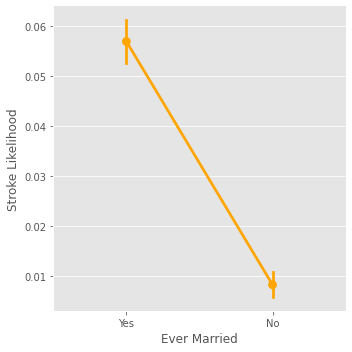

In [25]:
plot1 = sns.catplot(data = train, x = 'ever_married', y = 'stroke', kind = 'point', color = 'orange')
plot1.set_xlabels('Ever Married', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12);

Insight : Married patients have more likelihood of having Stroke than non-married.

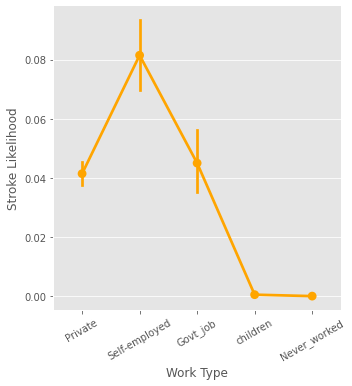

In [26]:
plot1 = sns.catplot(data = train, x = 'work_type', y = 'stroke', kind = 'point', color = 'orange')
plot1.set_xlabels('Work Type', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12)
plot1.set_xticklabels(rotation = 30); 

Patients who are self-employed are more likely to have stroke than private or govt. job.

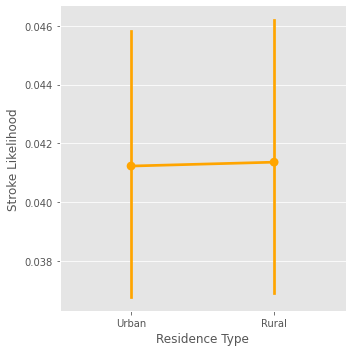

In [27]:
plot1 = sns.catplot(data = train, x = 'Residence_type', y = 'stroke', kind = 'point', color = 'orange')
plot1.set_xlabels('Residence Type', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12); 

No differnce on basis of residence type.

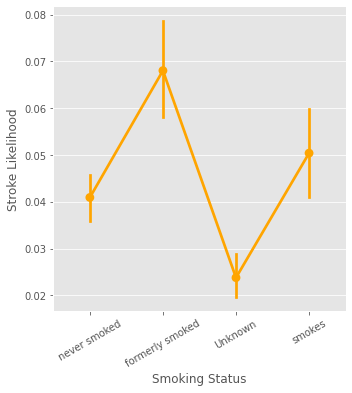

In [28]:
plot1 = sns.catplot(data = train, x = 'smoking_status', y = 'stroke', kind = 'point', color = 'orange')
plot1.set_xlabels('Smoking Status', fontsize = 12) 
plot1.set_ylabels('Stroke Likelihood', fontsize = 12)
plot1.set_xticklabels(rotation = 30); 

People who have smoked before, have more likelihood of stroke.

Relationship between feature and target variable.

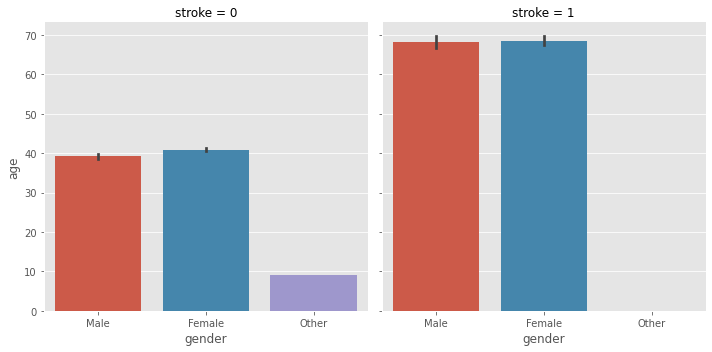

In [29]:
sns.catplot(data = train, x = 'gender', y = 'age', col = 'stroke', kind = 'bar');

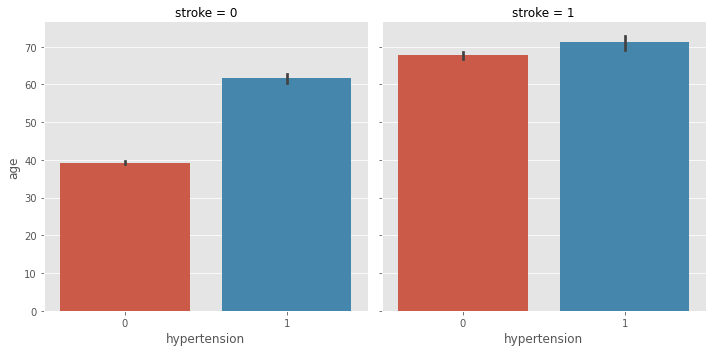

In [30]:
sns.catplot(data = train, x = 'hypertension', y = 'age', col = 'stroke', kind = 'bar');

Insight: From the above plots, we see that age and hypertsion have a relationship with stroke; that is, the older the patient is (with hypertension), the more likelily of having a stroke.

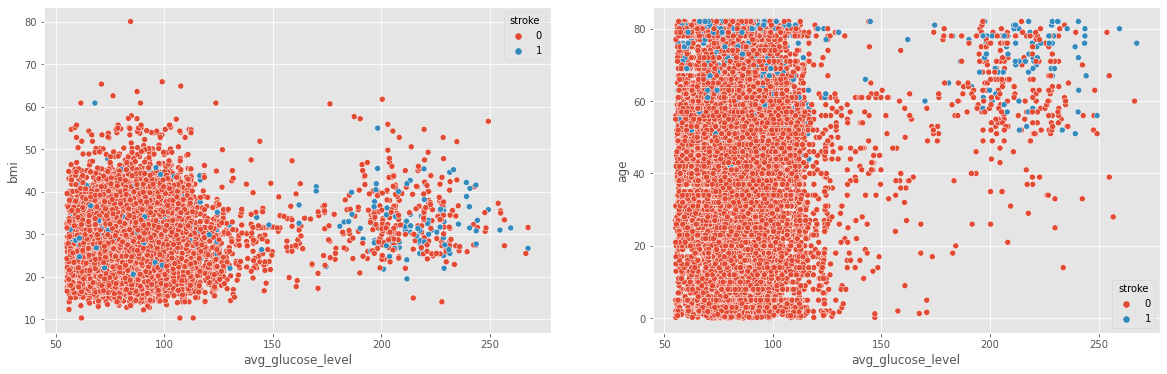

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (20, 6))

sns.scatterplot(ax = axes[0], x = 'avg_glucose_level', y = 'bmi', data = train, hue = 'stroke')
sns.scatterplot(ax = axes[1], x = 'avg_glucose_level', y = 'age', data = train, hue = 'stroke');

Insight: From the above plot, there is no a clear relationship among the numerical input features. However, in both plots we see that when avg_glucose_level is greater than 150 there are more patients who had a stroke.


**Logistic Model**

In [32]:
train_logit = train.copy()
test_logit = test.copy()

## Defining scaler
scaler = MinMaxScaler()

## Defining inputs and target
train_dummies = pd.get_dummies(train_logit[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

X = train_logit.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_logit['stroke']

test_dummies = pd.get_dummies(test_logit[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

test_logit = test_logit.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)
test_logit = pd.concat([test_logit, test_dummies], axis = 1)
test_logit = pd.DataFrame(scaler.fit_transform(test_logit), columns = test_logit.columns)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building logistic model
        logit_md = LogisticRegression(C = 0.2, penalty = 'l1', solver = 'saga', max_iter = 1000).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        logit_pred_1 = logit_md.predict_proba(X_test)[:, 1]
        logit_pred_2 = logit_md.predict_proba(test_logit)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, logit_pred_1))
        preds.append(logit_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

logit_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', logit_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.8834288620791657


In [33]:
## Building model in the entire train dataset
logit_md = LogisticRegression(C = 0.2, penalty = 'l1', solver = 'saga', max_iter = 10000).fit(X, Y)

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': logit_md.predict_proba(X)[:, 1]})
train_preds.head()

,stroke,stroke_pred
0,0,0.004354
1,0,0.007501
2,0,0.013771
3,0,0.034709
4,0,0.003920


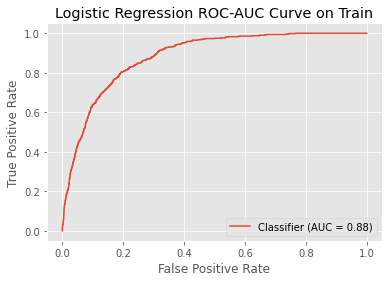

In [34]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('Logistic Regression ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

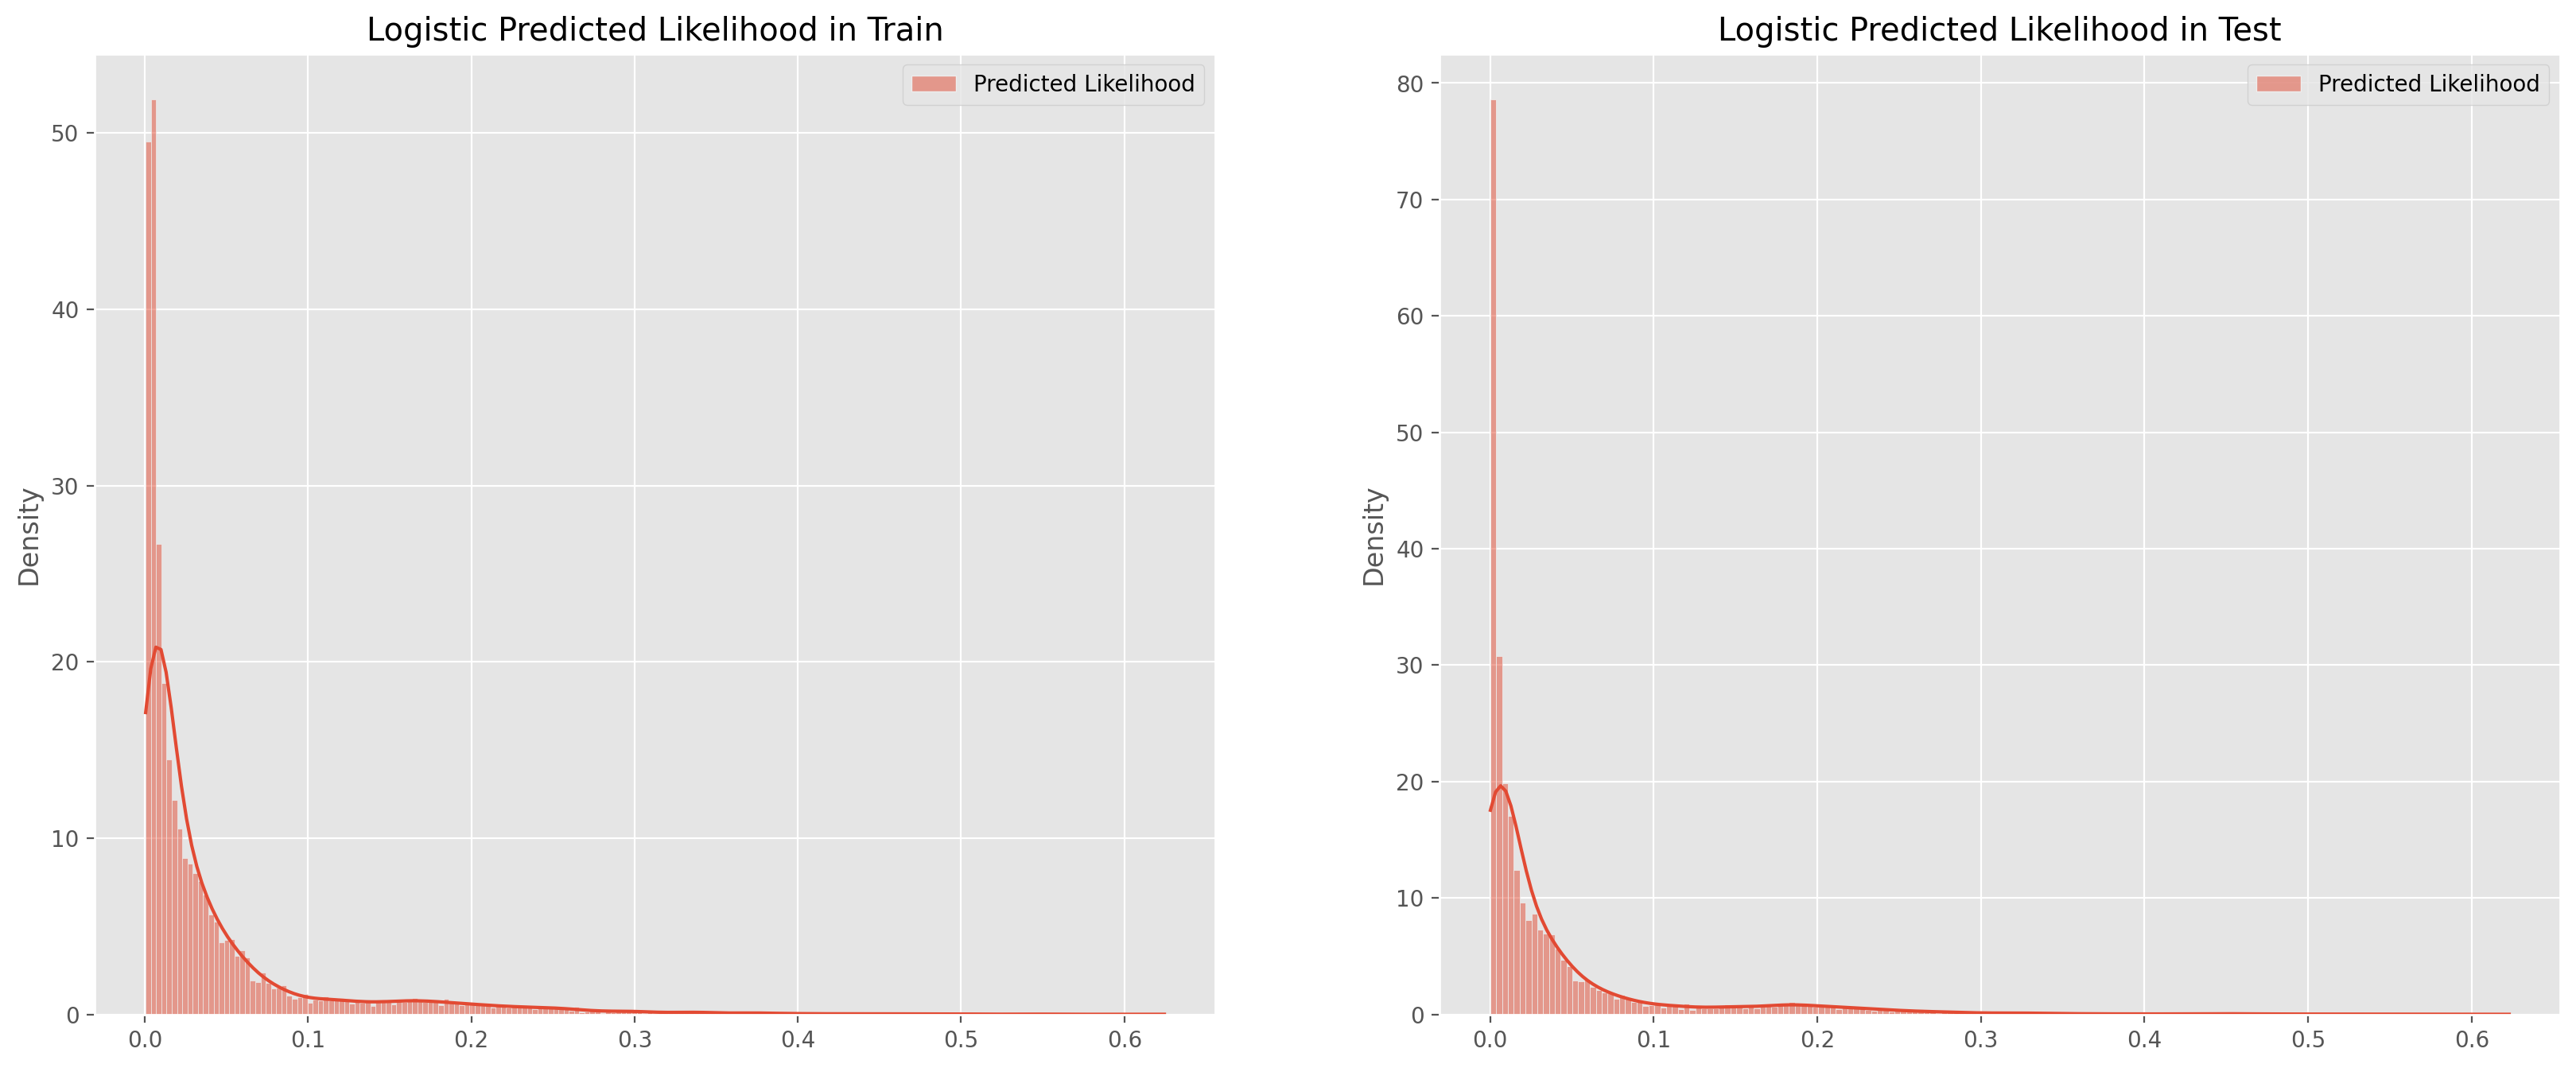

In [35]:
logit_preds_train = train_preds['stroke_pred']
logit_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': logit_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': logit_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'Logistic Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'Logistic Predicted Likelihood in Test')
plt.show();

In [36]:
submission['stroke'] = logit_preds_test
submission.to_csv('logistic_submission.csv', index = False)

**SVM Model**

In [37]:
cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building logistic model
        svm_md = SVC(C = 100, gamma = 1, kernel = 'rbf', probability = True).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        svm_pred_1 = svm_md.predict_proba(X_test)[:, 1]
        svm_pred_2 = svm_md.predict_proba(test_logit)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, svm_pred_1))
        preds.append(svm_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

svm_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', svm_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.695792613534485


In [38]:
## Building model in the entire train dataset
X_trans = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
svm_md = SVC(C = 100, gamma = 1, kernel = 'rbf', probability = True).fit(X_trans, Y)

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': svm_md.predict_proba(X_trans)[:, 1]})
train_preds.head()

,stroke,stroke_pred
0,0,0.047079
1,0,0.052438
2,0,0.051180
3,0,0.052431
4,0,0.021941


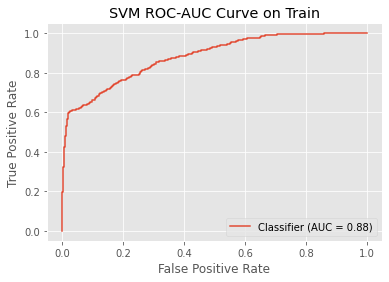

In [39]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('SVM ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

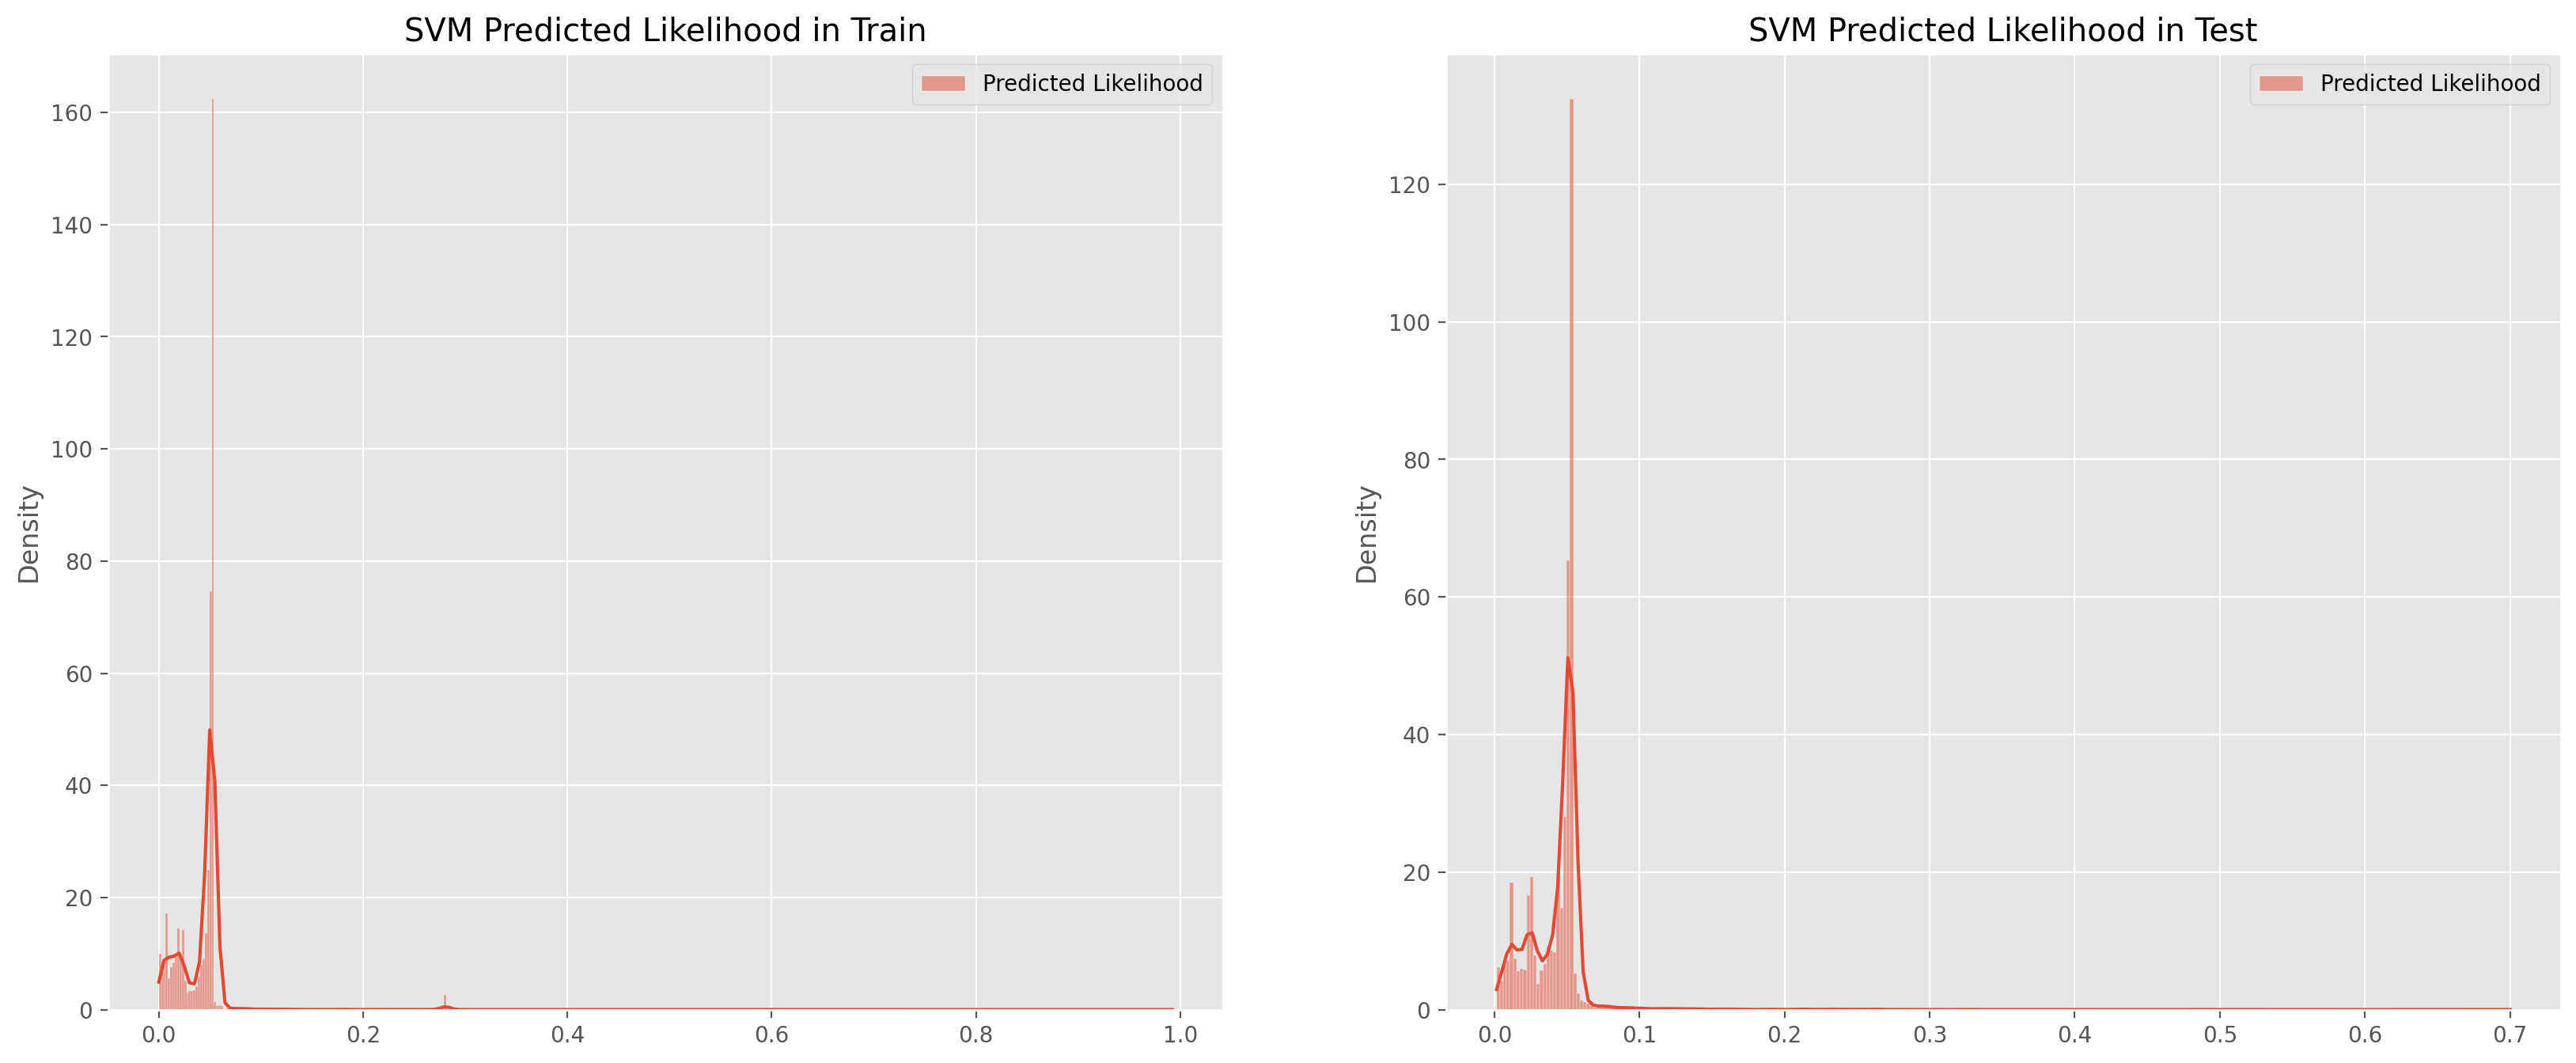

In [40]:
svm_preds_train = train_preds['stroke_pred']
svm_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': svm_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': svm_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'SVM Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'SVM Predicted Likelihood in Test')
plt.show();

In [41]:
# submission['stroke'] = svm_preds_test
# submission.to_csv('svm_submission.csv', index = False)

**Random Forest modeling**

In [42]:
train_RF = train.copy()
test_RF = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_RF[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

X = train_RF.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_RF['stroke']

test_dummies = pd.get_dummies(test_RF[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

test_RF = test_RF.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)
test_RF = pd.concat([test_RF, test_dummies], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        RF_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 300).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        RF_pred_1 = RF_md.predict_proba(X_test)[:, 1]
        RF_pred_2 = RF_md.predict_proba(test_RF)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, RF_pred_1))
        preds.append(RF_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

RF_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', RF_cv_score)


The roc-auc score over 5-folds (run 5 times) is: 0.8855005242255938


In [43]:
## Building model in the entire train dataset
RF_md = RandomForestClassifier(max_depth = 7, min_samples_leaf = 5, min_samples_split = 2, n_estimators = 300).fit(X, Y)

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': RF_md.predict_proba(X)[:, 1]})
train_preds.head()

,stroke,stroke_pred
0,0,0.014557
1,0,0.017076
2,0,0.016226
3,0,0.032622
4,0,0.005244


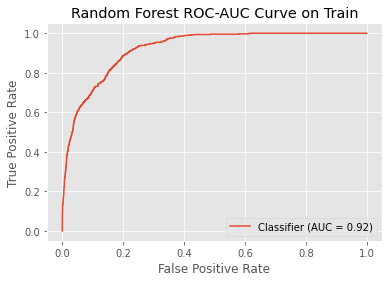

In [44]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('Random Forest ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

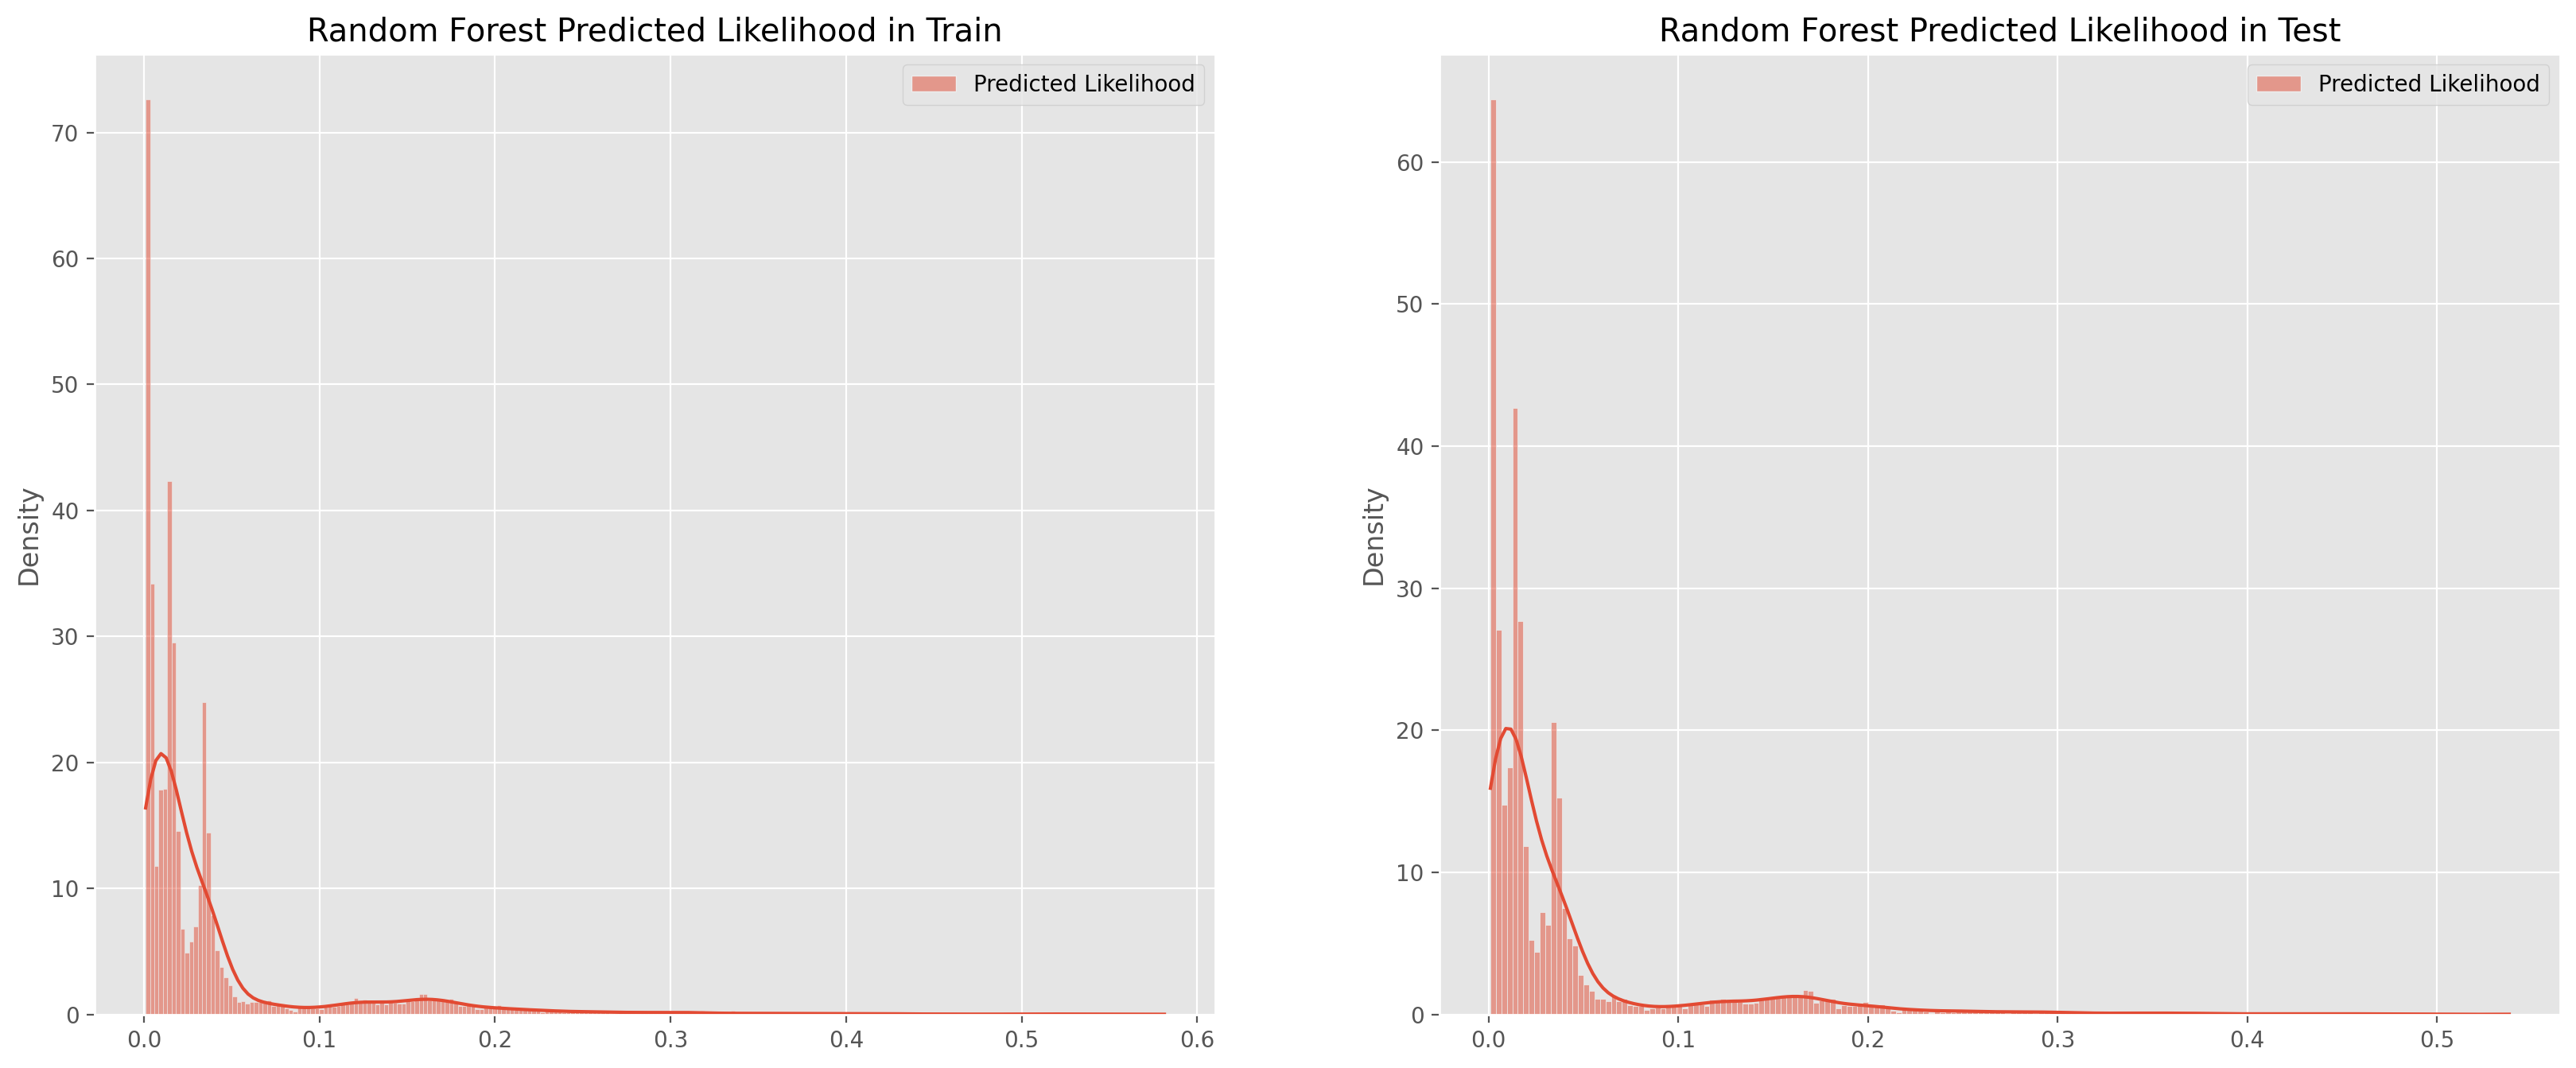

In [45]:
RF_preds_train = train_preds['stroke_pred']
RF_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': RF_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': RF_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'Random Forest Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'Random Forest Predicted Likelihood in Test')
plt.show();


In [46]:
# submission['stroke'] = RF_preds_test
# submission.to_csv('RF_submission.csv', index = False)

**XGBoost Model**

In [47]:
train_XGB = train.copy()
test_XGB = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_XGB[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

X = train_XGB.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_XGB['stroke']

test_dummies = pd.get_dummies(test_XGB[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

test_XGB = test_XGB.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)
test_XGB = pd.concat([test_XGB, test_dummies], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        XGB_md = XGBClassifier(colsample_bytree = 0.8, 
                               gamma = 0.3, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.8).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test_XGB)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

XGB_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.8853855128396434


In [48]:
## Building model in the entire train dataset
XGB_md = XGBClassifier(colsample_bytree = 0.8, 
                       gamma = 0.3, 
                       learning_rate = 0.01, 
                       max_depth = 5, 
                       min_child_weight = 10, 
                       n_estimators = 500, 
                       subsample = 0.8).fit(X, Y)

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': XGB_md.predict_proba(X)[:, 1]})
train_preds.head()

,stroke,stroke_pred
0,0,0.007921
1,0,0.009511
2,0,0.014932
3,0,0.030256
4,0,0.006667


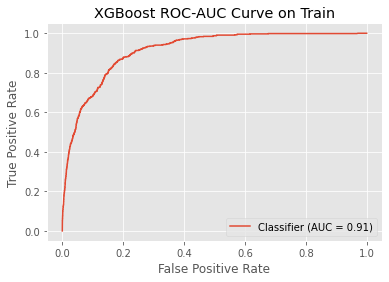

In [49]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('XGBoost ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

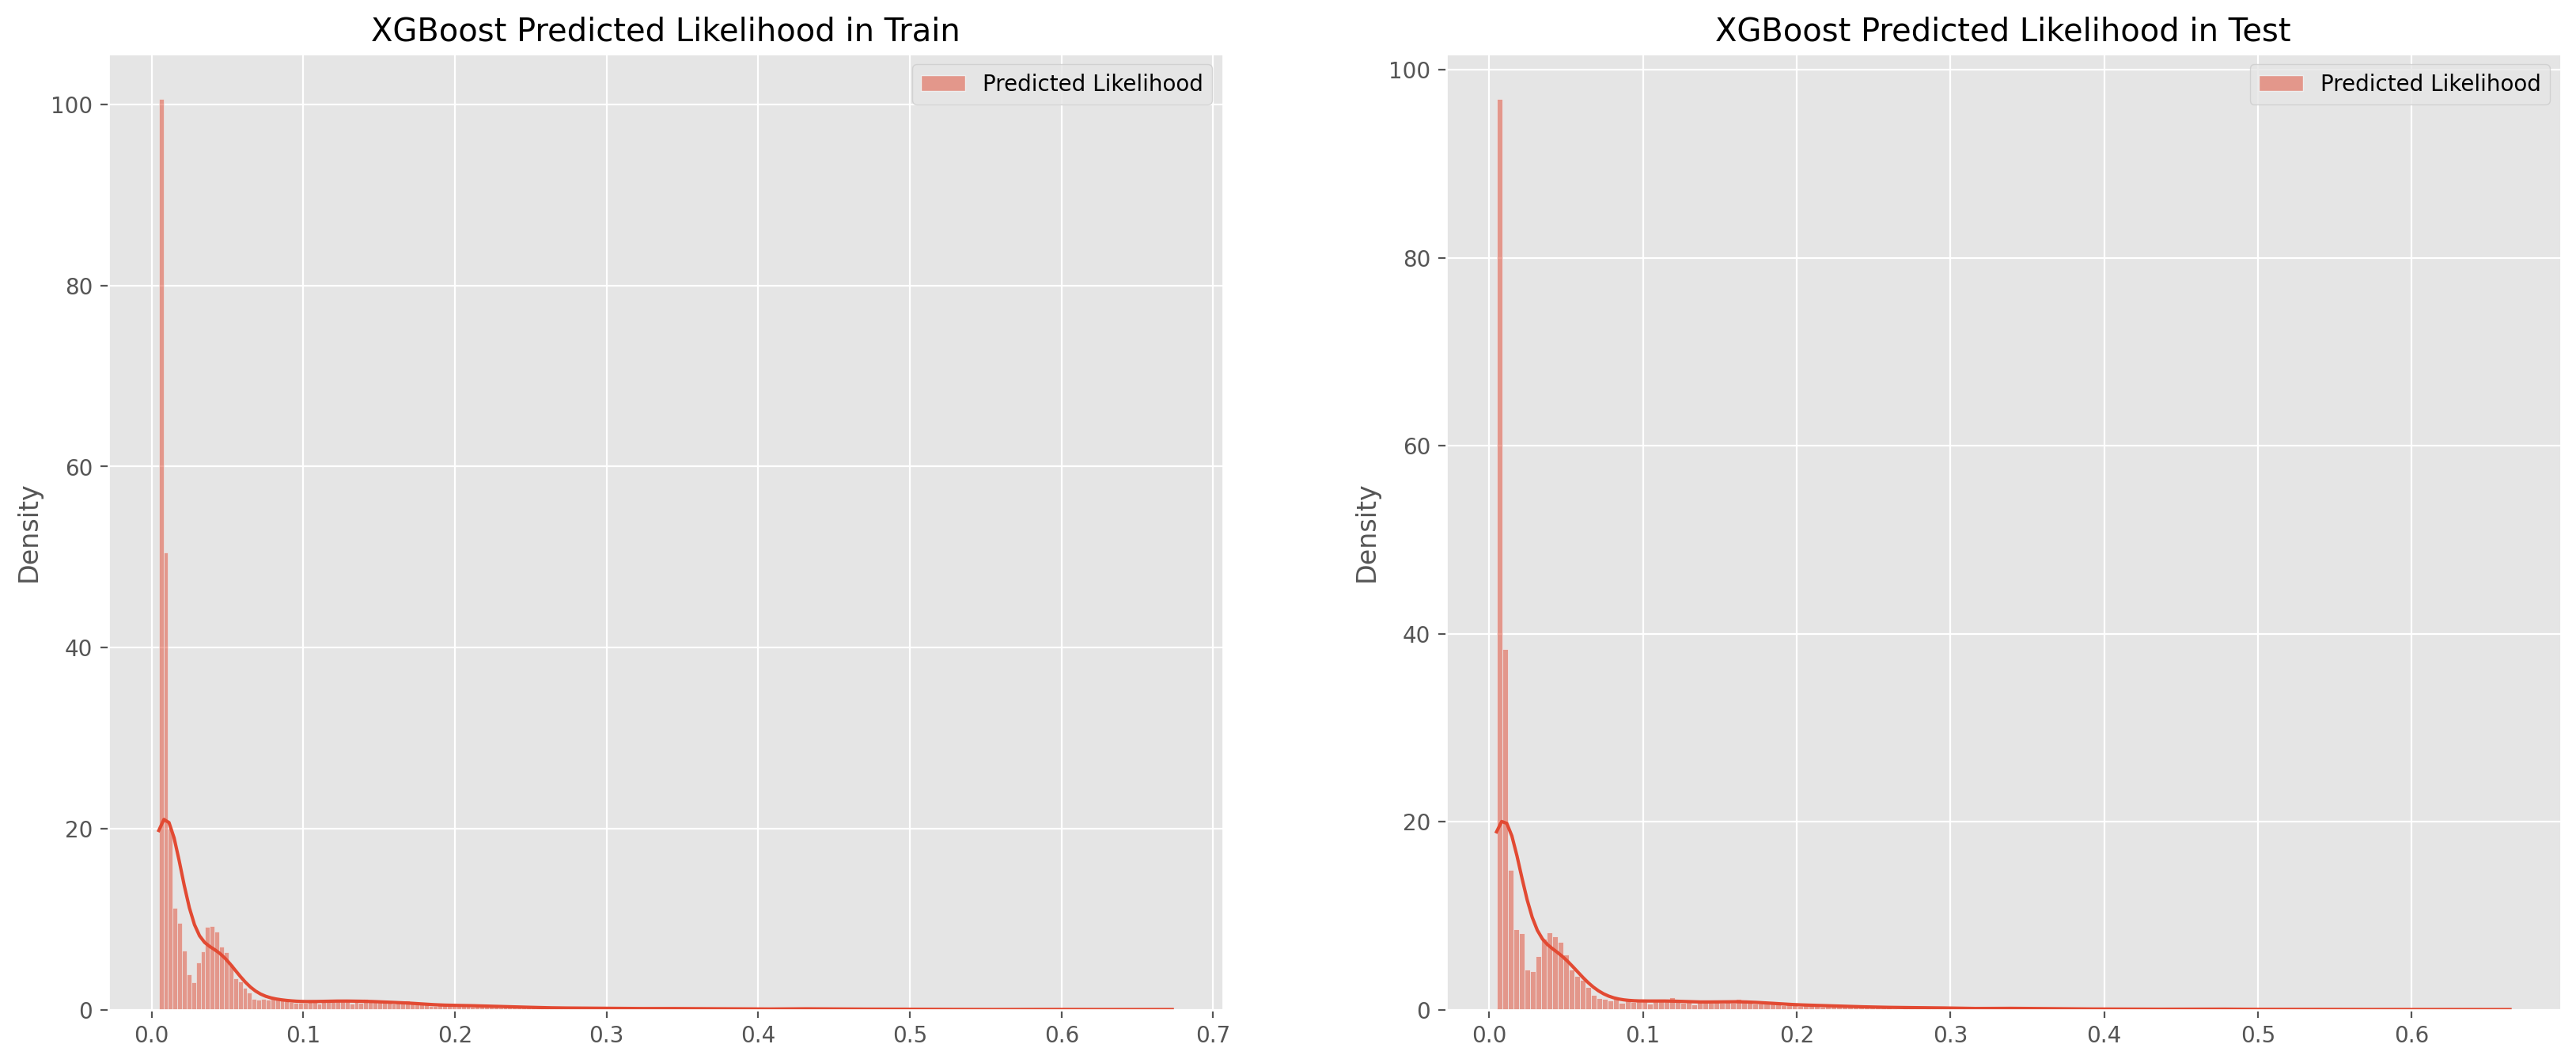

In [50]:
XGB_preds_train = train_preds['stroke_pred']
XGB_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': XGB_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': XGB_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'XGBoost Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'XGBoost Predicted Likelihood in Test')
plt.show();

In [51]:
# submission['stroke'] = XGB_preds_test
# submission.to_csv('XGB_submission.csv', index = False)

**LightGBM model**

In [52]:
train_lgb = train.copy()
test_lgb = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_lgb[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

X = train_lgb.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_lgb['stroke']

test_dummies = pd.get_dummies(test_lgb[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

test_lgb = test_lgb.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)
test_lgb = pd.concat([test_lgb, test_dummies], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 20,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

In [53]:
## Building model in the entire train dataset
lgb_md = LGBMClassifier(n_estimators = 1000,
                        max_depth = 7,
                        learning_rate = 0.01,
                        num_leaves = 20,
                        lambda_l1 = 3,
                        lambda_l2 = 3,
                        bagging_fraction = 0.7,
                        feature_fraction = 0.7).fit(X, Y)

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': lgb_md.predict_proba(X)[:, 1]})
train_preds.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,stroke,stroke_pred
0,0,0.001491
1,0,0.005081
2,0,0.010087
3,0,0.014281
4,0,0.001014


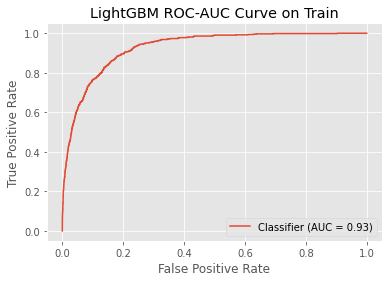

In [54]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('LightGBM ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

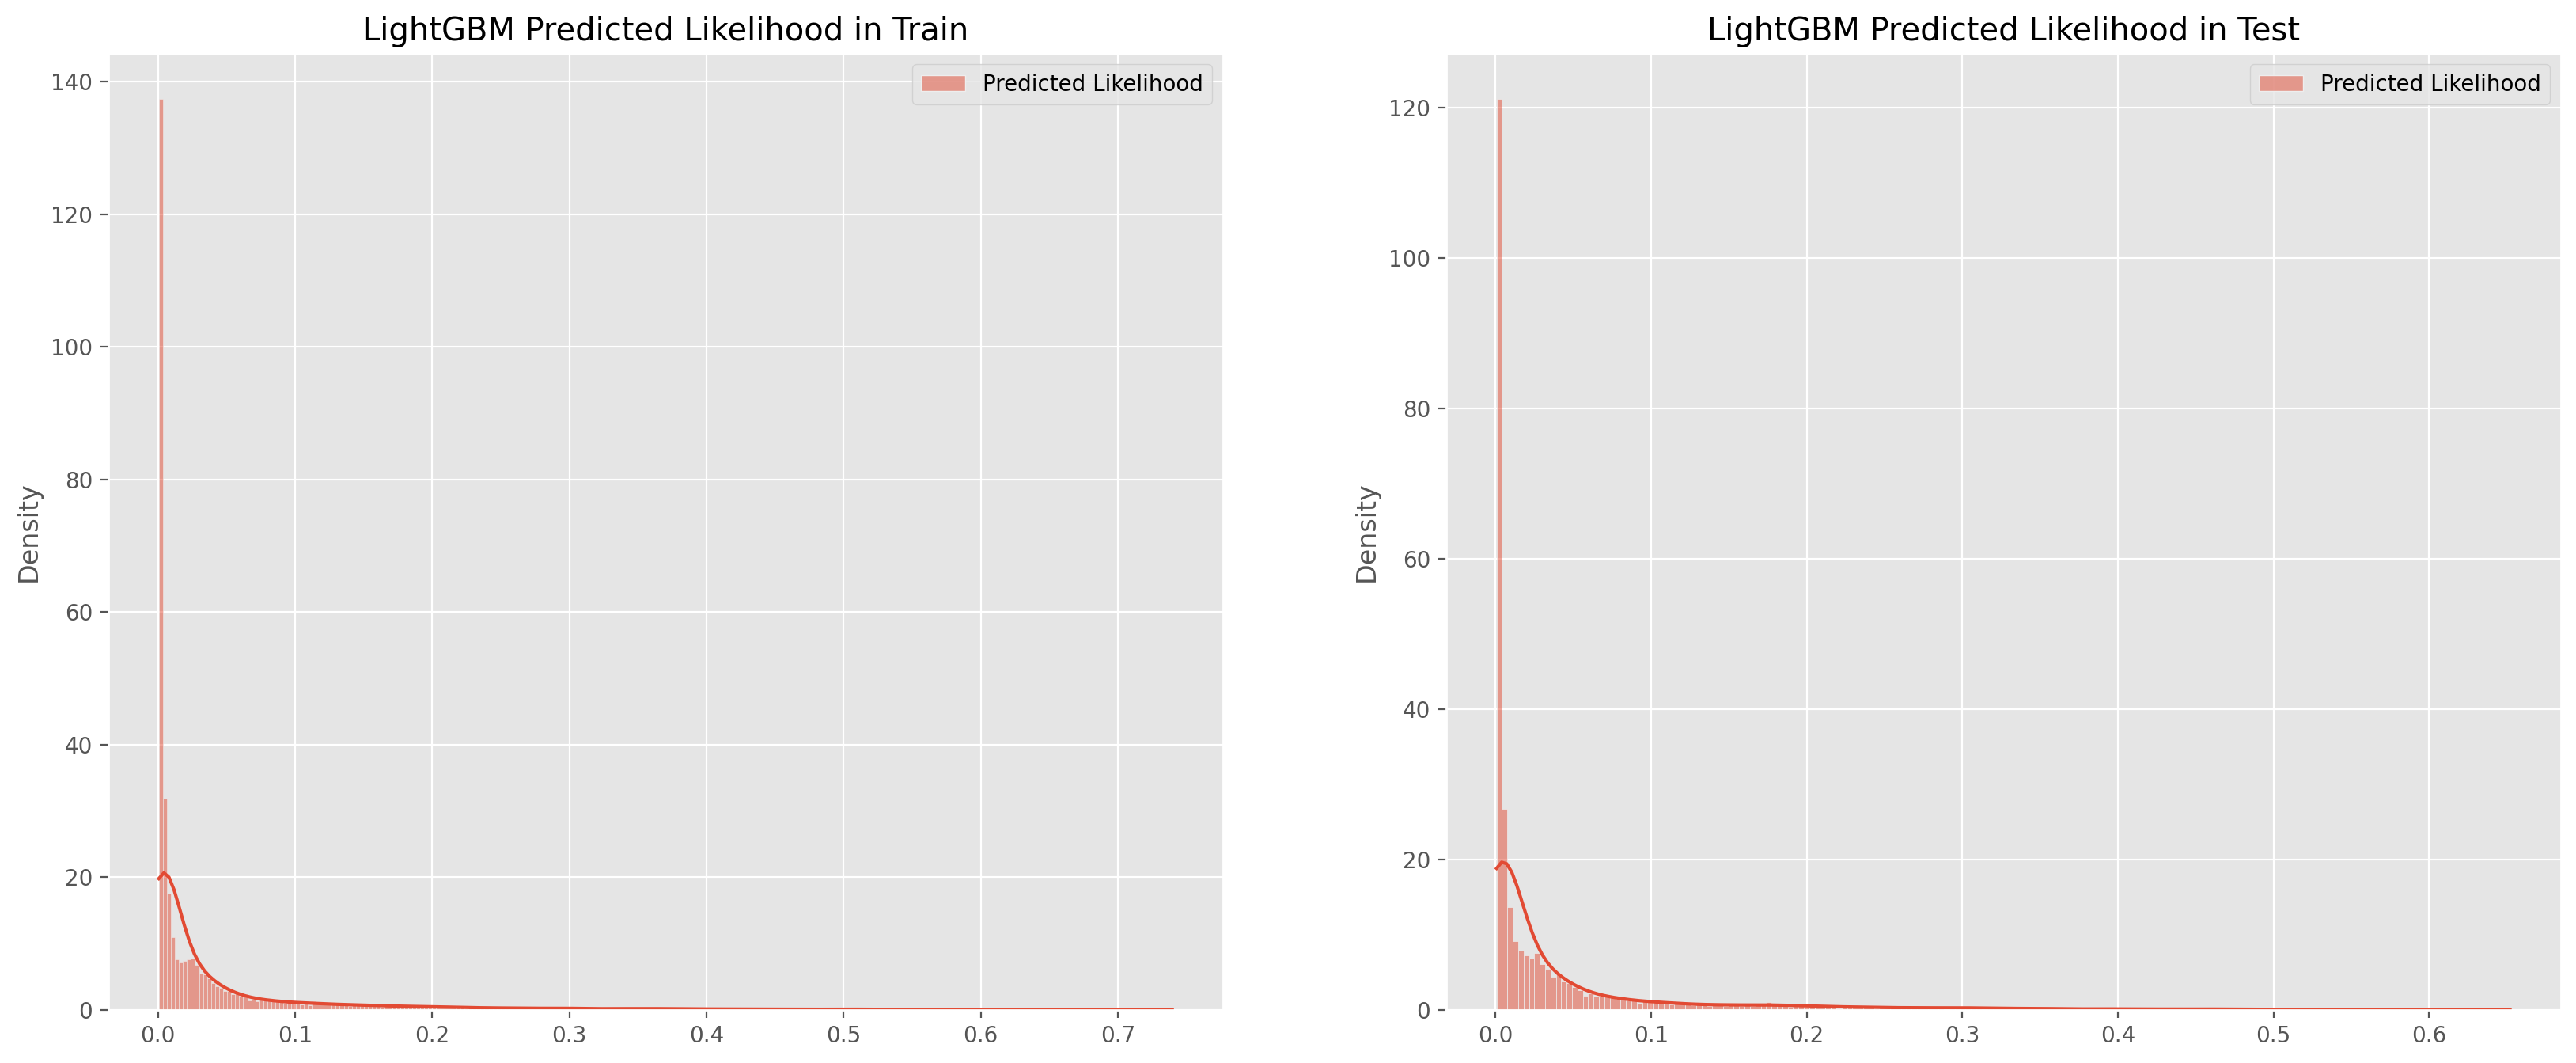

In [55]:
lgb_preds_train = train_preds['stroke_pred']
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': lgb_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': lgb_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'LightGBM Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'LightGBM Predicted Likelihood in Test')
plt.show();

In [56]:
# submission['stroke'] = lgb_preds_test
# submission.to_csv('LightGBM_submission.csv', index = False)

**CatBoost Model**

In [57]:
train_lgb = train.copy()
test_lgb = test.copy()

## Defining inputs and target
train_dummies = pd.get_dummies(train_lgb[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

X = train_lgb.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train_lgb['stroke']

test_dummies = pd.get_dummies(test_lgb[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'ever_married_No', 'work_type_children', 'Residence_type_Urban', 'smoking_status_Unknown'])

test_lgb = test_lgb.drop(columns = ['id', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], axis = 1)
test_lgb = pd.concat([test_lgb, test_dummies], axis = 1)

cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building the CatBoost model
        cat_md = CatBoostClassifier(iterations = 1000, 
                                    depth = 7,
                                    learning_rate = 0.01,
                                    rsm = 0.5,
                                    subsample = 0.931,
                                    l2_leaf_reg = 69,
                                    min_data_in_leaf = 20,
                                    random_strength = 0.175,
                                    random_seed = 836,
                                    task_type = 'CPU',
                                    bootstrap_type = 'Bernoulli',
                                    grow_policy = 'SymmetricTree',
                                    loss_function = 'Logloss',
                                    verbose = False).fit(X_train, Y_train)
            
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict_proba(X_test)[:, 1]
        cat_pred_2 = cat_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, cat_pred_1))
        preds.append(cat_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

cat_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', cat_cv_score)

The roc-auc score over 5-folds (run 5 times) is: 0.8855446011389068


In [58]:
## Building model in the entire train dataset
cat_md = CatBoostClassifier(iterations = 1000,
                            depth = 7,
                            learning_rate = 0.01,
                            rsm = 0.5,
                            subsample = 0.931,
                            l2_leaf_reg = 69,
                            min_data_in_leaf = 20,
                            random_strength = 0.175,
                            random_seed = 836,
                            task_type = 'CPU',
                            bootstrap_type = 'Bernoulli',
                            grow_policy = 'SymmetricTree',
                            loss_function = 'Logloss',
                            verbose = False).fit(X, Y)
                  

train_preds = pd.DataFrame({'stroke': Y, 'stroke_pred': cat_md.predict_proba(X)[:, 1]})
train_preds.head()

,stroke,stroke_pred
0,0,0.004012
1,0,0.005834
2,0,0.007278
3,0,0.027744
4,0,0.002577


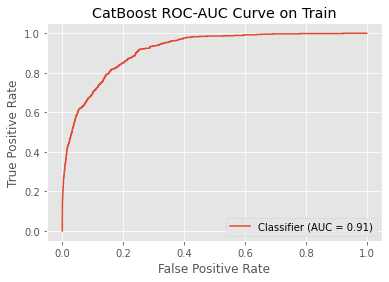

In [59]:
RocCurveDisplay.from_predictions(train_preds['stroke'], train_preds['stroke_pred'])
plt.title('CatBoost ROC-AUC Curve on Train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

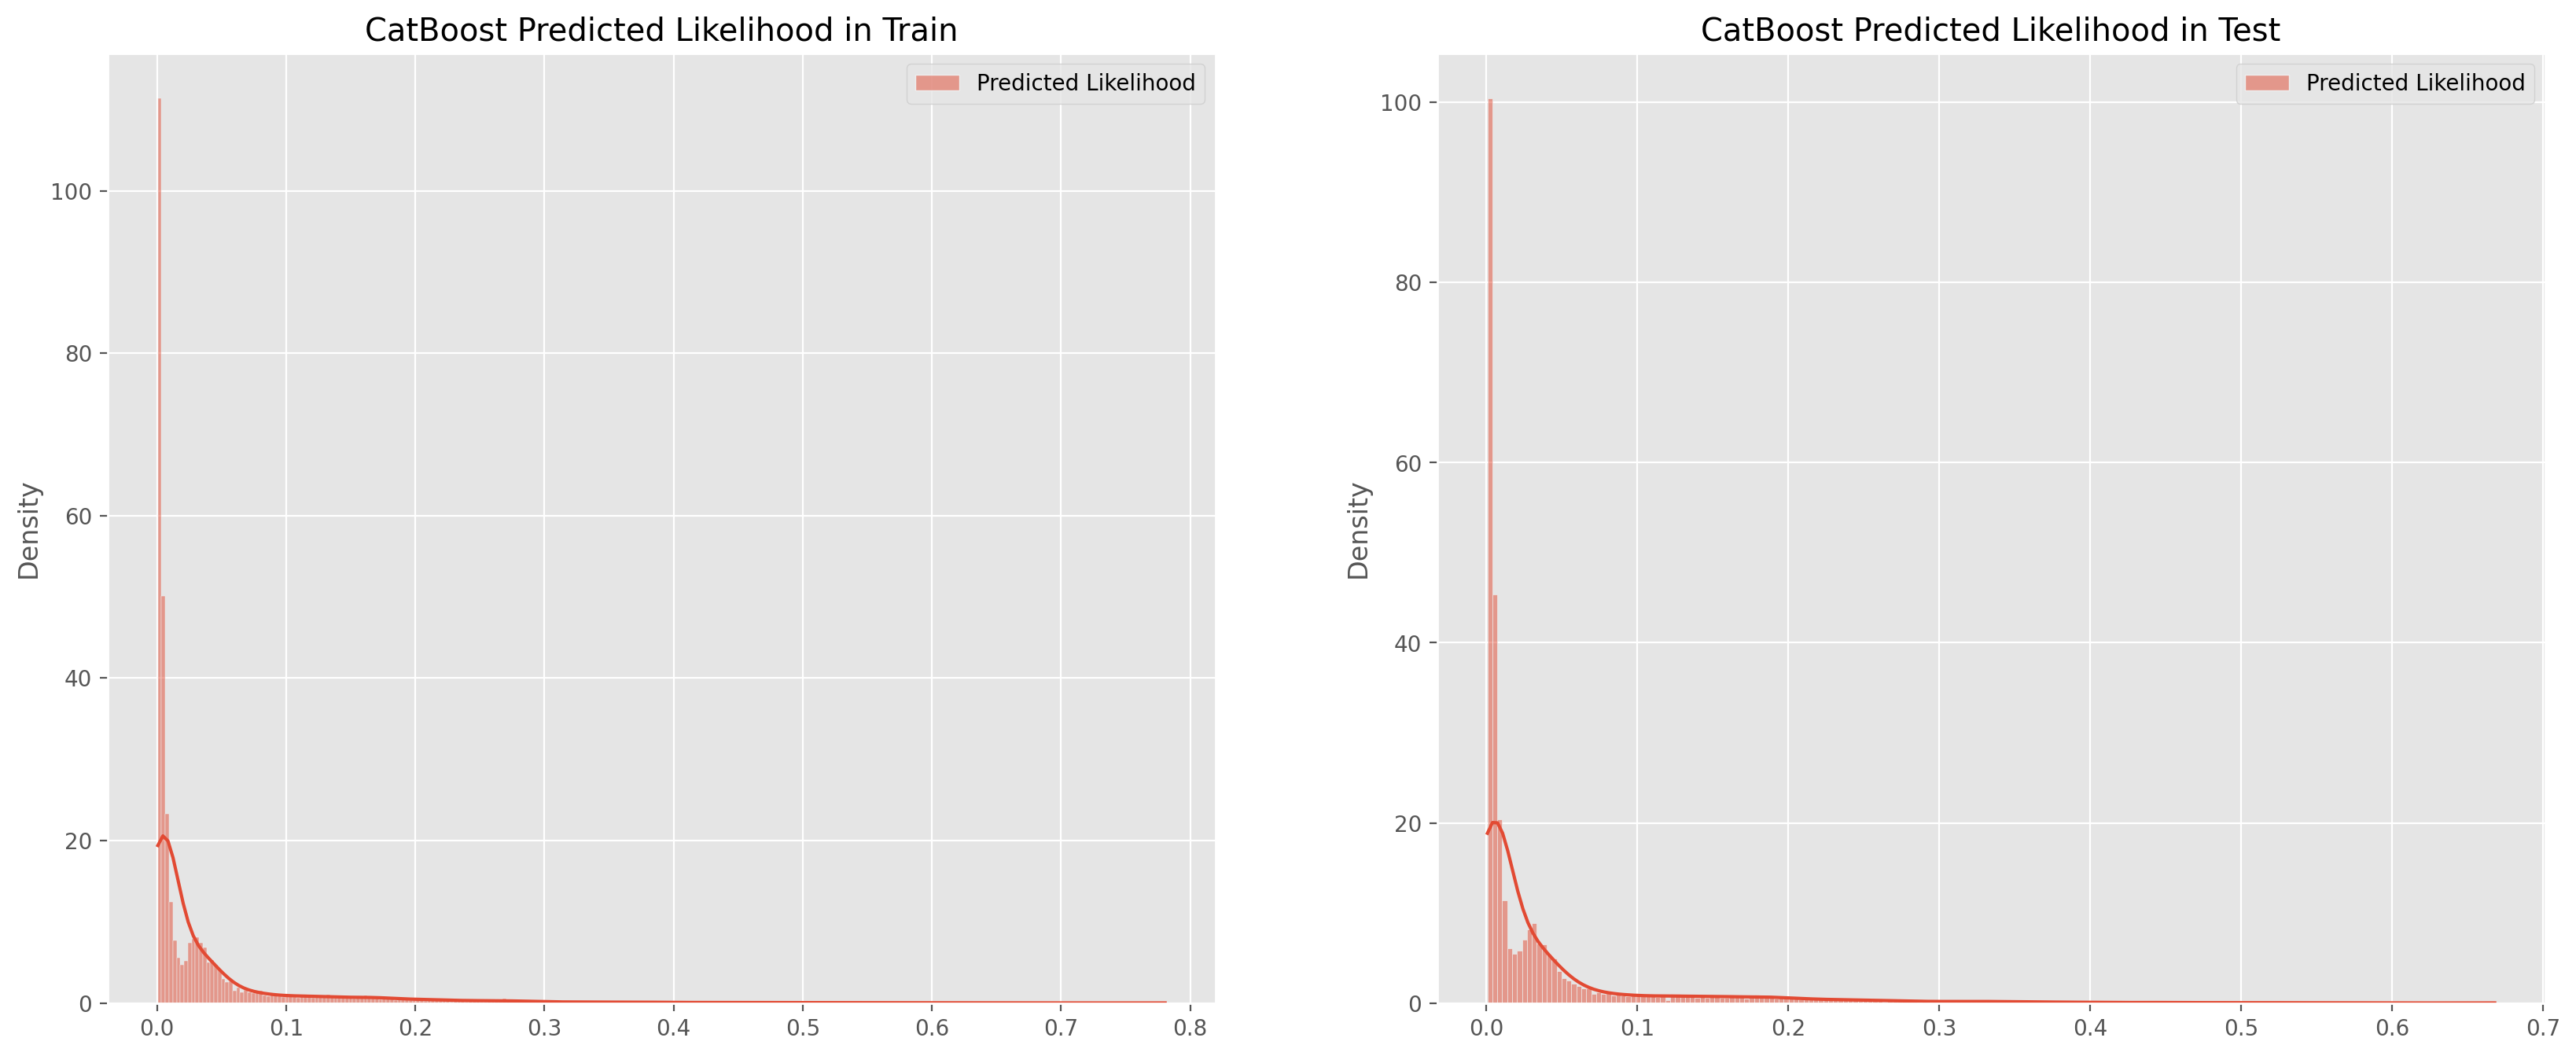

In [60]:
cat_preds_train = train_preds['stroke_pred']
cat_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

data1 = pd.DataFrame({'Predicted Likelihood': cat_preds_train})
data2 = pd.DataFrame({'Predicted Likelihood': cat_preds_test})

fig, axes = plt.subplots(1, 2, figsize = (20, 8), dpi = 200)
sns.histplot(data = data1, kde = True, stat = 'density', ax = axes[0]).set(title = 'CatBoost Predicted Likelihood in Train')
sns.histplot(data = data2, kde = True, stat = 'density', ax = axes[1]).set(title = 'CatBoost Predicted Likelihood in Test')
plt.show();

In [61]:
# submission['stroke'] = cat_preds_test
# submission.to_csv('CatBoost_submission.csv', index = False)

**Ensemble Learning**

In [62]:
wtot = logit_cv_score + svm_cv_score + RF_cv_score + XGB_cv_score + lgb_cv_score + cat_cv_score
w1 = logit_cv_score / wtot
w2 = svm_cv_score / wtot
w3 = RF_cv_score / wtot
w4 = XGB_cv_score / wtot
w5 = lgb_cv_score / wtot
w6 = cat_cv_score / wtot

ensemble_pred = w1*logit_preds_test + w2*svm_preds_test + w3*RF_preds_test + w4*XGB_preds_test + w5*lgb_preds_test + w6*cat_preds_test

submission['stroke'] = ensemble_pred
submission.head()

,id,stroke
0,15304,0.039296
1,15305,0.175830
2,15306,0.004724
3,15307,0.059781
4,15308,0.016583


In [63]:
# submission.to_csv('ensemble_submission.csv', index = False)